# Bike Helmet Detection - Training Notebook

In this notebook we will fine-tune YOLOv8n on a public dataset of bike drivers wearing or not wearing a helmet.

[Kaggle version](https://www.kaggle.com/code/alexandredj/bikehelmetdetection-yolov8n-training)

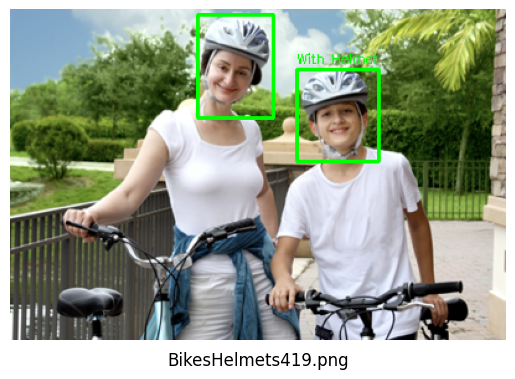

# Prerequisites

In [ ]:
!pip install ultralytics

# Module imports

In [ ]:
import os
import shutil
import zipfile
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random
import numpy as np
from ultralytics import YOLO
from PIL import Image

# Project paths

In [ ]:
project_dir = '/content/'
dataset_dir = os.path.join(project_dir, 'dataset')

images_dir = os.path.join(dataset_dir, "images")
annotations_dir = os.path.join(dataset_dir, "annotations")
labels_dir = os.path.join(dataset_dir, "labels")

train_img_dir = os.path.join(dataset_dir, "train", "images")
train_labels_dir = os.path.join(dataset_dir, "train", "labels")
val_img_dir = os.path.join(dataset_dir, "val", "images")
val_labels_dir = os.path.join(dataset_dir, "val", "labels")
test_img_dir = os.path.join(dataset_dir, "test", "images")
test_videos_dir = os.path.join(dataset_dir, "test", "videos")

models_dir = os.path.join(project_dir, "models")
predict_dir = os.path.join(project_dir, "predict")

# Check hardware if training on GPU

In [ ]:
!nvidia-smi

# Download Helmet Detection Dataset from Kaggle

We are downloading and unzipping the [Helmet Detection](https://www.kaggle.com/datasets/andrewmvd/helmet-detection) dataset from kaggle. For this, you need to create a folder in your drive and add the path to the environment.  

The dataset will be downloaded as a zip, we unzip it then in the dataset folder.

In [ ]:
os.makedirs(dataset_dir, exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = dataset_dir

if not os.path.isdir(annotations_dir) and not os.path.isdir(images_dir):
    # download dataset
    !kaggle datasets download -d andrewmvd/helmet-detection
    # unzip dataset
    filepath = '/content/helmet-detection.zip'

    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
else:
    print('Annotations and images folder already exist - Skip unzipping dataset')

# Parse XML and preview dataset images with bounding box

Load a random image from the dataset, parse bounding box information and draw it on image.

Green: With Helmet  
Red: Without Helmet

In [ ]:
def parse_xml(xml_file):
    '''
    Parse the XML file and extract image information and bounding boxes

    Args:
        xml_file: str: path to the XML file

    Return:
        image_name: str: name of the image file
        image_shape: tuple: shape of the image
        labels_and_bboxes: list: list of tuples containing labels and bounding boxes
    '''

    # Parse the XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image information
    image_name = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    depth = int(root.find('size/depth').text)
    image_shape = width, height, depth

    labels_and_bboxes = []

    # Loop through each object in the XML
    for obj in root.findall('object'):
        # Extract label and bounding box coordinates for each object
        label = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Append label and bounding box to the list
        labels_and_bboxes.append((label, (xmin, ymin, xmax, ymax)))

    return image_name, image_shape, labels_and_bboxes

def draw_bounding_boxes(img_file, labels_and_bboxes):
    '''
    Draw bounding boxes on the image

    Args:
        img_file: str: path to the image file
        labels_and_bboxes: list: list of tuples containing labels and bounding boxes
    '''
    # Load the image
    image = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)

    # Draw bounding boxes on the image
    for label, bbox in labels_and_bboxes:
        xmin, ymin, xmax, ymax = bbox
        rgb_color = (0, 255, 0) if label == 'With Helmet' else (255, 0, 0)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), rgb_color, 2)
        cv2.putText(image, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.35, rgb_color, 1)

    # Display the image with bounding boxes
    plt.axis(False)
    plt.title(os.path.split(img_file)[-1], y=-0.1)
    plt.imshow(image)

def get_random_img_xml():
    '''
    Get a random image and its corresponding XML file

    Return:
        img_file: str: path to the image file
        xml_file: str: path to the XML file
    '''

    # pick a random image from the dataset
    img_name = random.choice(os.listdir(images_dir))
    # img_name = 'BikesHelmets99.png'
    img_file = os.path.join(images_dir, img_name)
    xml_file = os.path.join(annotations_dir, img_name[:-4]+'.xml')

    return img_file, xml_file


# Main
img_file, xml_file = get_random_img_xml()
image_name, image_shape, labels_and_bboxes = parse_xml(xml_file)
draw_bounding_boxes(img_file, labels_and_bboxes)

# Convert input labels
The dataset provides PNG images and XML labels using the Pascal VOC format.  

Example:

```xml
<annotation>
    <folder>images</folder>
    <filename>BikesHelmets1.png</filename>
    <size>
        <width>400</width>
        <height>300</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>With Helmet</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>161</xmin>
            <ymin>0</ymin>
            <xmax>252</xmax>
            <ymax>82</ymax>
        </bndbox>
    </object>
</annotation>
```

However, Yolo requires a different label format as input. For each image, a txt file should list the classes and the bounding boxes top left and bottom right points, normalized btw 0 and 1.

{class} {bbox x1} {bbox y1} {bbox x2} {bbox y2}

```
# Example:
1 0.51625 0.13666666666666666 0.2275 0.2733333333333333
```

Let's generate our text labels from the xml files.


In [ ]:
def create_labels(xml_dir, labels_dir):
    '''
    Create labels for each image in the dataset. Ignore image if invalid bboxes (coordinates out of image shape)

    Args:
        xml_dir: str: path to the directory containing the annotation xml files
        labels_dir: str: path to the directory where the labels will be saved
    '''

    # browse through annotation xml files and extract the class and bounding box coordinates
    os.makedirs(labels_dir, exist_ok=True)

    annotations = [file for file in os.listdir(xml_dir) if file.lower().endswith('.xml')]

    count = 0
    ignored = 0

    for xml_file in annotations:

        image_name, image_shape, labels_and_bboxes = parse_xml(os.path.join(xml_dir, xml_file))

        # save label and bbox to a text file with same name than image file
        txt_file = os.path.join(labels_dir, xml_file.replace('.xml', '.txt'))

        file_corrupt = False

        with open(txt_file, 'w') as f:

            for label, bbox in labels_and_bboxes:

                # get label
                label = 1 if label == 'With Helmet' else 0

                # compute bounding box center, width and height from bbox coordinates
                x_center = (bbox[0] + bbox[2]) / 2
                y_center = (bbox[1] + bbox[3]) / 2
                width = bbox[2] - bbox[0]
                height = bbox[3] - bbox[1]

                # normalize all values between 0 and 1
                x_center /= image_shape[0]
                y_center /= image_shape[1]
                width /= image_shape[0]
                height /= image_shape[1]

                # check if values are within the range 0 and 1
                if x_center > 1 or y_center > 1 or width > 1 or height > 1:
                    file_corrupt = True
                    break

                f.write(f"{label} {x_center} {y_center} {width} {height}\n")

        # delete corrupted files (values don't make any sense)
        if file_corrupt:
            ignored += 1
            f.close()
            os.remove(txt_file)
            continue

        print(f"\rImage: {image_name}     ", end='', flush=True)
        count += 1


    print(f"\n>> {count} labels created | {ignored} images ignored")

# Main
create_labels(annotations_dir, labels_dir)

# Create Train/Validation sets
Split images and labels into a training and validation sets with an 80/20 ratio.

In [ ]:
def create_train_val_split():
    '''
    Create a train and val split of the images/labels.
    '''

    # make sure target dirs exist
    for dir in [train_img_dir, val_img_dir, train_labels_dir, val_labels_dir]:
        os.makedirs(dir, exist_ok=True)

    # copy images randomly to train and val folders using 80/20 split
    images = [img[:-4] for img in os.listdir(images_dir)]
    random.shuffle(images)
    split = int(0.8 * len(images))

    count_total = len(images)
    count_train = 0
    count_val = 0
    count_ignored = 0

    for i in range(len(images)):

        # check if label exists (some images are corrupted and don't have a label file)
        if not os.path.exists(os.path.join(labels_dir, f"{images[i]}.txt")):
            count_ignored += 1
            count_total -= 1
            continue

        if i < split:
            shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), train_img_dir)
            shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), train_labels_dir)
            count_train += 1
        else:
            shutil.copy(os.path.join(images_dir, f"{images[i]}.png"), val_img_dir)
            shutil.copy(os.path.join(labels_dir, f"{images[i]}.txt"), val_labels_dir)
            count_val += 1

        count_total -= 1

        print(f"\rImages: {count_total} >> Train: {count_train} | Val: {count_val} | Ignored: {count_ignored}     ", end='', flush=True)

# Main
create_train_val_split()

# Generate the training config file
To initiate training, yolo requires a yaml file containing the paths to our train and validation sets, as well as our output classes. Let's generate it first.

In [ ]:
config_file_path = f'{dataset_dir}/config.yaml'

config_file_contents = f'''path: {dataset_dir}  # root dir
train: train/images  # train dir
val: val/images  # val dir

# Classes
names:
  0: without helmet
  1: with helmet
'''

with open(config_file_path, 'w') as f:
    f.write(config_file_contents)

print(f"Config file written successfully at location {config_file_path}")



# Train the model
You need to chose a pre-trained model to start from, you will get better results than training it from scratch.  
Pick a version from [Ultralytics GitHub](https://github.com/ultralytics/ultralytics).  
You can simply enter its name below, it will be downloaded automatically before training.  
Below we are fine-tuning YOLOv8n pre-trained on the COCO dataset.

In [ ]:
# deactivate WandDB if you don't wanna use it
os.environ['WANDB_DISABLED'] = 'true'

# Load a Yolo8 model, we will use the nano version
if not os.path.isfile(config_file_path):
    raise FileNotFoundError(f'Config yaml file not found at location {config_file_path}.')

# Base model to fine-tune
yolo = YOLO('yolov8n.pt')  # default, pre-trained on the Coco dataset

yolo.train(
    data=config_file_path,
    epochs=100,  # aim for at least 100 epochs
    patience=20,  # EarlyStopping
    batch=-1,  # automatic batch size
    save_period=10,  # save model every 10 epochs
    dropout=0.2,  # add some dropout to reduce overfitting
    plots=True  # plot results
)

# Validate model results

In [ ]:
valid_results = yolo.val()
print(valid_results)

# Testing the model on a picture

In [ ]:
# load latest model
model = YOLO(os.path.join(models_dir, 'best_260424_0028.pt'))

# load random image
img_file, _ = get_random_img_xml()

# predict on image and save result
results = model.predict(source=img_file, classes=[0, 1], save=True, conf=0.5)

for result in results:

    # save image
    os.makedirs(predict_dir, exist_ok=True)
    img_pred = os.path.join(predict_dir, os.path.split(img_file)[-1])
    result.save(img_pred)

    # load and display the image with the predicted bounding boxes
    image = Image.open(img_pred)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Testing the model on webcam

Grab your helmet and plug-in your webcam, let's try our prediction model on ourselves!  
This section won't work on kaggle, download your model and test it locally.

In [ ]:
# load latest model
model = YOLO(os.path.join(models_dir, 'best_260424_0028.pt'))

# Set webcam as source and set resolution
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

# set webcam fps
cap.set(cv2.CAP_PROP_FPS, 15)

# Load my model
model = YOLO(f'{models_dir}/best_260424_0028.pt')

while cap.isOpened():

    # load and flip current frame
    success, frame = cap.read()
    frame = cv2.flip(frame, 1)

    if success:
        # track on frame and plot result
        results = model.track(frame, verbose=False, conf=0.1)
        frame = results[0].plot()
        cv2.imshow("Webcam Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# That's it!
You can now download your fine-tuned YOLOv8 model and use it to predict on images/webcam/videos.